<a href="https://colab.research.google.com/github/fluorescentlightpower/mifi_homework/blob/main/%D0%A1%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%C2%AB%D0%9E%D1%82_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%B0_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9_%D0%BA_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8E_%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель проекта — закрепить понимание принципов работы алгоритмов деревьев решений, ансамблей и кластеризации через собственную реализацию и анализ их поведения на данных.

**Этап 1. Реализация дерева решений**

Простая реализация дерева решений для задачи классификации.

Реализуйте функции:

расчёта критерия Джини или энтропии;
поиска наилучшего разбиения по признаку;
рекурсивного построения дерева с ограничением по глубине (max_depth) или по числу объектов в узле (min_samples_split);
предсказания для новых наблюдений.

In [220]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [221]:
# Генерация тестового набора данных

X, y = make_classification(
    n_samples=400,
    n_features=2,  # два признака для наглядной визуализации границ решений
    n_informative=2,
    n_redundant=0,
    random_state=42
)

In [222]:
df = pd.DataFrame(X)
df['y'] = y

In [223]:
# Функция расчета энтропии Шеннона

def entropy(y):
    p = y.value_counts(normalize=True)
    return -np.sum(p * np.log2(p))

In [224]:
# Разбиение по заданному предикату

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

In [225]:
# Расчет взвешенной неоднородности

def weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    return N_left / N * criterion(y_left) + N_right / N * criterion(y_right)

In [226]:
# Кандидаты порогов предикатов для перебора

def candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

In [227]:
# Поиск наилучшего разбиения

def best_split(X, y, criterion):
    M = X.shape[1]
    min_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            impurity = weighted_impurity(X, y, split_params, criterion)
            if impurity < min_impurity:
                min_impurity = impurity
                optimal_split_params = split_params
    return optimal_split_params

In [228]:
# Построение дерева

def build_tree(X, y, depth=0, max_depth=5, min_samples_split=2, criterion=entropy):

    # Условия остановки. Если выполнено, формирование и возврат листа

    if (
        depth >= max_depth
        or len(y) < min_samples_split
        or criterion(y) == 0
    ):
        return {
            'type': 'leaf',
            'class': y.value_counts().idxmax() # Самый распространенный
        }                                      # класс в листе => результат классификации

    # Если остановки нет, поиск наилучшего разбиения по признаку

    split_params = best_split(X, y, criterion)

    # Если разбиение не найдено (признак может оказаться константным), нужно формировать лист

    if split_params is None:
        return {
            'type': 'leaf',
            'class': y.value_counts().idxmax()
        }

    # Если разбиение найдено, строится пень

    j, t = split_params

    # Разделение данных на левую и правую ветвь

    X_left, y_left, X_right, y_right = split(X, y, split_params)

    # Рекурсивный вызов функции для простроения левой и правой ветвей пня

    left_subtree = build_tree(
        X_left, y_left,
        depth=depth + 1,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion
    )

    right_subtree = build_tree(
        X_right, y_right,
        depth=depth + 1,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion
    )

    # Возврат узла

    return {
        'type': 'node',
        'feature': j,
        'threshold': t,
        'left': left_subtree,
        'right': right_subtree
    }

In [229]:
# Предсказание для одной строки

def predict_sample(x, tree):

    # Если лист, классификация окончена, возврат класса

    if tree['type'] == 'leaf':
        return tree['class']

    # Если не лист, рекурсивный переход на следующий уровень по предикату

    if x.iloc[tree['feature']] <= tree['threshold']:
        return predict_sample(x, tree['left'])
    else:
        return predict_sample(x, tree['right'])

In [230]:
# Предсказание для набора данных

def predict(X, tree):
    return X.apply(lambda row: predict_sample(row, tree), axis=1)

Для оценки качества обучения вычисляется базовый уровень (baseline) - просто возврат каждый раз самого распространенного класса

In [231]:
# Расчет и вывод accuracy

def print_metrics(y_pred_train, y_pred_test, y_train, y_test):

    accuracy_train = (y_pred_train == y_train).mean()
    baseline_train = (y_train == y_train.mode()[0]).mean()
    accuracy_test = (y_pred_test == y_test).mean()
    baseline_test = (y_test == y_test.mode()[0]).mean()

    return pd.DataFrame({
    'Accuracy (модель)': [accuracy_train, accuracy_test],
    'Accuracy (baseline)': [baseline_train, baseline_test]
}, index=['Обучающая', 'Тестовая'])


Разделение набора данных на обучающую и тестовую выборки, обучение и проверка на тесте

In [232]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.3, random_state=42)

In [233]:
tree = build_tree(X_train, y_train, criterion=entropy)

y_pred_train = predict(X_train, tree)
y_pred_test = predict(X_test, tree)

print ('\n', 'Таблица accuracy, собственная реализация', '\n')
display(print_metrics(y_pred_train, y_pred_test, y_train, y_test))


 Таблица accuracy, собственная реализация 



,Accuracy (модель),Accuracy (baseline)
Обучающая,0.971429,0.517857
Тестовая,0.950000,0.550000


Визуализация границ решения

In [234]:
def plot_decision_boundary(X, y, tree, step=0.1):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step)
    )

    grid = pd.DataFrame(
        np.c_[xx.ravel(), yy.ravel()],
        columns=X.columns
    )

    Z = predict(grid, tree)
    Z = np.array(Z).reshape(xx.shape)

    plt.contourf(xx, yy, Z)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1])
    plt.show()

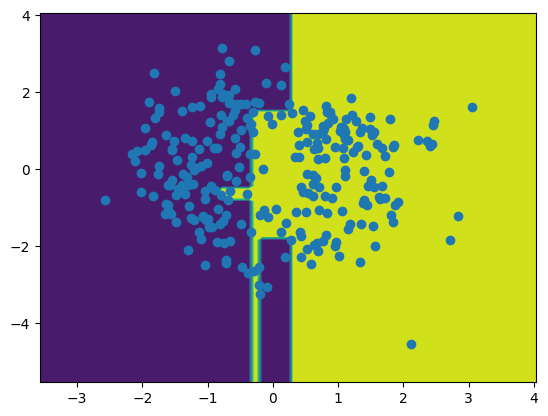

In [235]:
plot_decision_boundary(X_train, y_train, tree)

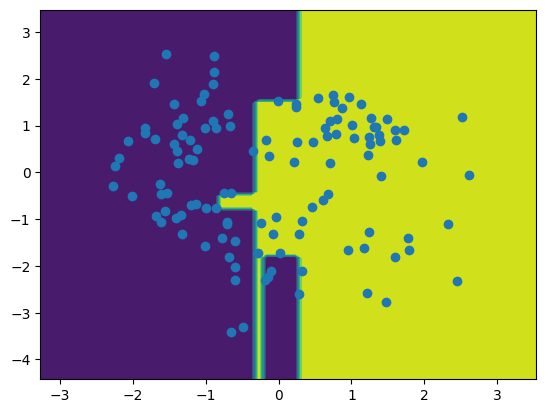

In [236]:
plot_decision_boundary(X_test, y_test, tree)

Сравнение с реализацией scikit-learn

In [237]:
sk_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=2, random_state=42)
sk_tree.fit(X_train, y_train)

# предсказания (train)
y_pred_sk_train = sk_tree.predict(X_train)

# предсказания (test)
y_pred_sk_test = sk_tree.predict(X_test)

print ('\n', 'Таблица accuracy, реализация sklearn', '\n')
display(print_metrics(y_pred_sk_train, y_pred_sk_test, y_train, y_test))


 Таблица accuracy, реализация sklearn 



,Accuracy (модель),Accuracy (baseline)
Обучающая,0.971429,0.517857
Тестовая,0.950000,0.550000


Печать дерева

In [238]:
def print_tree(tree, depth=0):
    depth += 1
    if tree['type'] == 'leaf':
        print('   ' * depth, f'class: {tree['class']}')
    else:
        print('   ' * depth, f'feature_{tree['feature']} <= {tree['threshold']:.3f}:')
        print_tree(tree['left'], depth=depth)
        print('   ' * depth, f'feature_{tree['feature']} > {tree['threshold']:.3f}')
        print_tree(tree['right'], depth=depth)

In [239]:
print_tree(tree)

    feature_0 <= 0.282:
       feature_0 <= -0.270:
          feature_1 <= -0.472:
             feature_1 <= -0.811:
                feature_1 <= -1.462:
                   class: 0
                feature_1 > -1.462
                   class: 0
             feature_1 > -0.811
                feature_0 <= -0.843:
                   class: 0
                feature_0 > -0.843
                   class: 1
          feature_1 > -0.472
             feature_0 <= -0.582:
                class: 0
             feature_0 > -0.582
                feature_0 <= -0.578:
                   class: 1
                feature_0 > -0.578
                   class: 0
       feature_0 > -0.270
          feature_1 <= 1.548:
             feature_1 <= -1.740:
                feature_0 <= -0.205:
                   class: 1
                feature_0 > -0.205
                   class: 0
             feature_1 > -1.740
                feature_0 <= -0.103:
                   class: 1
                feature_0 > -0.1

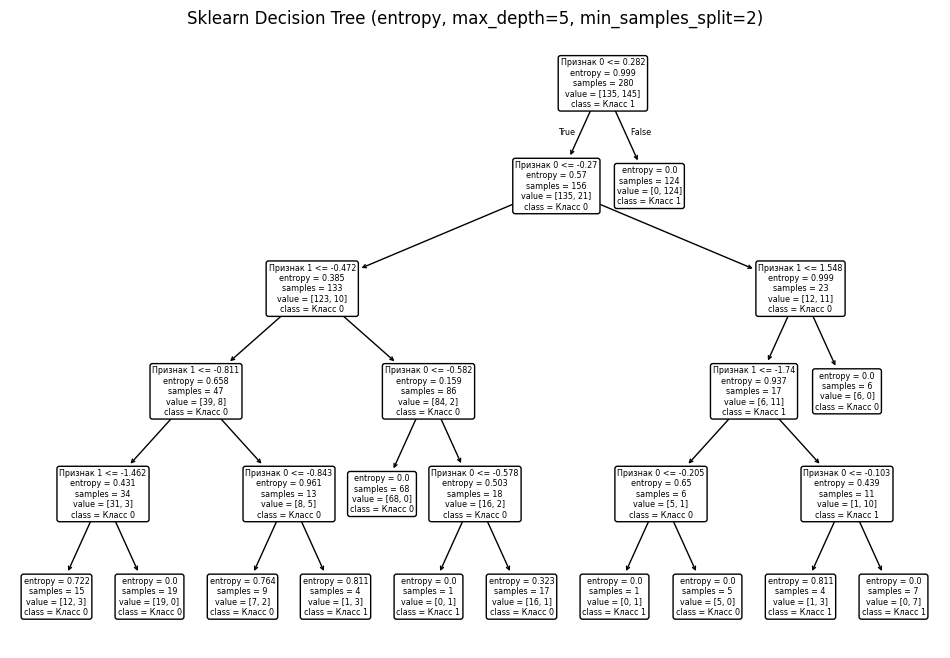

In [240]:
plt.figure(figsize=(12,8))
plot_tree(sk_tree, feature_names=['Признак 0', 'Признак 1'], class_names=['Класс 0', 'Класс 1'], filled=False, rounded=True)
plt.title('Sklearn Decision Tree (entropy, max_depth=5, min_samples_split=2)')
plt.show()

По метрике accuracy можно заключить, что модель обладает обобщающей способностью, а не просто выучила выборку, так как предсказание существенно лучше присвоения каждый раз самого распространенного класса. Тем не менее, есть эффект переобучения, так как accuracy для обучающей и тестовой выборок заметно отличаются. Реализация scikit-learn дала точно такой же результат по метрике, хотя при этом конкретное строение дерева может отличаться.

**Этап 2. Ансамбль деревьев (бэггинг)**

Функция, которая:

случайно выбирает bootstrap-выборку (с возвращением) из обучающих данных размером, равным обучающей выборке;
обучает на ней одно дерево решений;
сохраняет модель.

In [241]:
def one_tree (df, random_state=42):
    rng = np.random.default_rng(random_state)
    selected_indices = rng.choice(df.index, size=df.shape[0], replace=True)
    df_sample = df.loc[selected_indices].reset_index(drop=True)
    X, y = df_sample.iloc[:,:-1], df_sample.iloc[:,-1]
    return build_tree(X, y)

Повтор построения деревьев несколько раз по бутстрэпам из обучающей выборки,

In [242]:
df_train = pd.DataFrame(X_train)
df_train['y_train'] = y_train
df_test = pd.DataFrame(X_test)
df_test['y_test'] = y_test

N = 1

y_bag_train = pd.DataFrame(
    np.zeros((y_train.shape[0], N)),
    index=y_train.index
)

y_bag_test = pd.DataFrame(
    np.zeros((y_test.shape[0], N)),
    index=y_test.index
)

for i in range(N):
    tree = one_tree(df_train, random_state=100 + 5*i)
    y_bag_train.iloc[:, i] = predict(X_train, tree)
    y_bag_test.iloc[:, i] = predict(X_test, tree)

y_bag_train_vote = y_bag_train.mode(axis=1)[0]
y_bag_test_vote = y_bag_test.mode(axis=1)[0]

print ('\n', 'Таблица accuracy, реализация бэггинга вручную', '\n')
display(print_metrics(y_bag_train_vote, y_bag_test_vote, y_train, y_test))



 Таблица accuracy, реализация бэггинга вручную 



,Accuracy (модель),Accuracy (baseline)
Обучающая,0.950,0.517857
Тестовая,0.925,0.550000


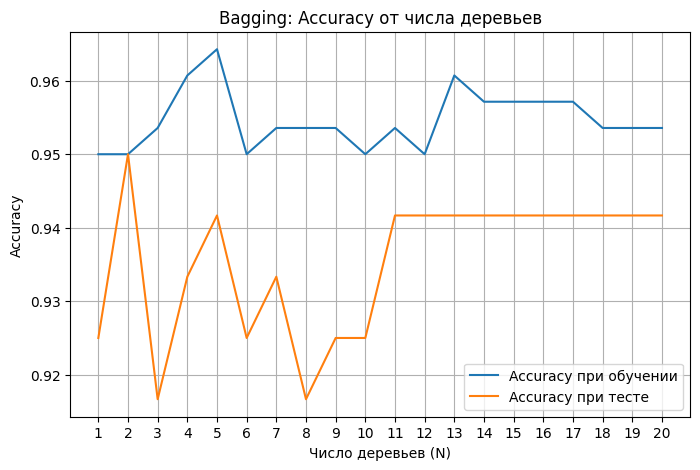

In [243]:
N_values = range(1, 21)   # от 1 до 20 деревьев
acc_train_list = []
acc_test_list = []

for N in N_values:
    y_bag_train = pd.DataFrame(
        np.zeros((y_train.shape[0], N)),
        index=y_train.index
    )

    y_bag_test = pd.DataFrame(
        np.zeros((y_test.shape[0], N)),
        index=y_test.index
    )

    for i in range(N):
        tree = one_tree(df_train, random_state=100 + 5*i)
        y_bag_train.iloc[:, i] = predict(X_train, tree)
        y_bag_test.iloc[:, i] = predict(X_test, tree)

    y_bag_train_vote = y_bag_train.mode(axis=1)[0]
    y_bag_test_vote = y_bag_test.mode(axis=1)[0]

    metrics = print_metrics(y_bag_train_vote, y_bag_test_vote, y_train, y_test)

    acc_train_list.append(metrics.loc['Обучающая', 'Accuracy (модель)'])
    acc_test_list.append(metrics.loc['Тестовая', 'Accuracy (модель)'])

plt.figure(figsize=(8, 5))
plt.plot(N_values, acc_train_list, label='Accuracy при обучении')
plt.plot(N_values, acc_test_list, label='Accuracy при тесте')
plt.xlabel('Число деревьев (N)')
plt.xticks(N_values)
plt.ylabel('Accuracy')
plt.title('Bagging: Accuracy от числа деревьев')
plt.legend()
plt.grid(True)
plt.show()

In [244]:
print('Таблица с результатами для разных N', '\n')
pd.DataFrame(
    {
        'Accuracy при обучении': acc_train_list,
        'Accuracy при тесте': acc_test_list
    },
    index=N_values
)

Таблица с результатами для разных N 



,Accuracy при обучении,Accuracy при тесте
1,0.950000,0.925000
2,0.950000,0.950000
3,0.953571,0.916667
4,0.960714,0.933333
5,0.964286,0.941667
6,0.950000,0.925000
7,0.953571,0.933333
8,0.953571,0.916667
9,0.953571,0.925000
10,0.950000,0.925000


Расчет приведен для 400 точек исходных данных. Здесь видно, что с увеличением числа деревьев метрика accuracy становится стабильной и не меняется с увеличением числа деревьев выше 11 на тестовой выборке. В целом заметно повышение метрики на обучающей выборке, но оно менее выражено. При использовании 200 точек исходных данных метрика на тестовых данных гораздо ниже, потому что данных гораздо меньше для выявления закономерности. Модель скорее запоминает, а не обобщает.

График выглядел так:

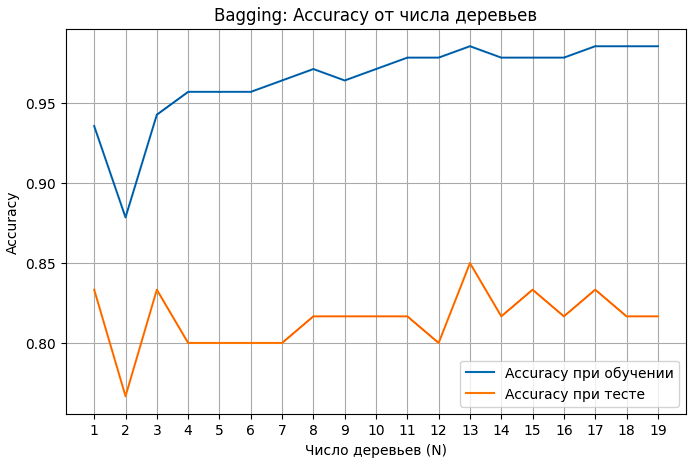

**Этап 3. Кластеризация и понижение размерности**

In [245]:
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)

# Масштабирование
X = (X - X.mean()) / X.std()

In [260]:
# Функция, реализующая kmeans

def kmeans(X, k, max_iter=100, tol=1e-4, random_state=42):

    X_np = X.values
    n_samples, n_features = X_np.shape

    # Инициализация генератора
    rng = np.random.default_rng(seed=random_state)

    # Случайная инициализация центроидов
    indices = rng.choice(n_samples, k, replace=False)
    centroids = X_np[indices]

    i = 0
    shift = np.inf

    while i < max_iter and shift > tol:

        # Матрица расстояний
        distances = np.zeros((n_samples, k))

        for j in range(k):
            # Каждый центроид повторяется n_samples раз, получается матрица
            centroid_array = np.tile(centroids[j], (n_samples, 1))

            # Разность и построчная норма
            distances[:, j] = np.linalg.norm(X_np - centroid_array, axis=1)

        # Назначение кластеров. Кластеры - номера столбцов с минимумом для каждой строки
        labels = np.argmin(distances, axis=1)

        # Пересчёт центроидов
        new_centroids = np.zeros((k, n_features))

        # Перебор всех центроидов и усреднение координат всех точек, которые сейчас в кластере
        for j in range(k):

            # Все точки из текущего кластера на данный момент
            points = X_np[labels == j]

            # Если кластер не пуст, новый центроид - средние координаты точек в кластере
            if len(points):
                new_centroids[j] = points.mean(axis=0)

            # Если кластер опустел, новый центроид - самая далекая точка
            else:
                furthest_point = np.argmax(np.min(distances, axis=1))
                new_centroids[j] = X_np[furthest_point]

        # Расчет критерия сходимости
        shift = np.linalg.norm(centroids - new_centroids)

        centroids = new_centroids
        i += 1

    return centroids, labels, i

In [261]:
# применение kmeans

centroids, labels, i = kmeans(X, 3, max_iter=100, tol=1e-4, random_state=42)

In [262]:
# Реализация PCA

def pca(X, n_components):

    X_np = X.values.astype(float)

    # Ковариационная матрица
    cov_matrix = np.cov(X_np, rowvar=False)

    # Собственные векторы и значения
    eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

    # Сортировка по убыванию собственных значений
    sorted_idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_idx]
    eig_vecs = eig_vecs[:, sorted_idx]

    # Выбор нужного числа компонент
    components = eig_vecs[:, :n_components]

    # Проекция данных
    X_pca = np.dot(X_np, components)

    return X_pca, components, eig_vals

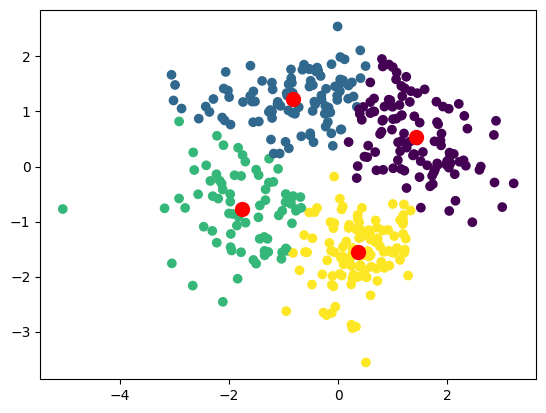

In [263]:
# Кластеризация после PCA

X_pca, components, eig_vals = pca(df, n_components=2)
centroids, labels, i = kmeans(pd.DataFrame(X_pca), 4, max_iter=100, tol=1e-4, random_state=42)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Центроиды
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='red',
    marker='o',       # форма маркера
    s=100             # размер
)

plt.show()

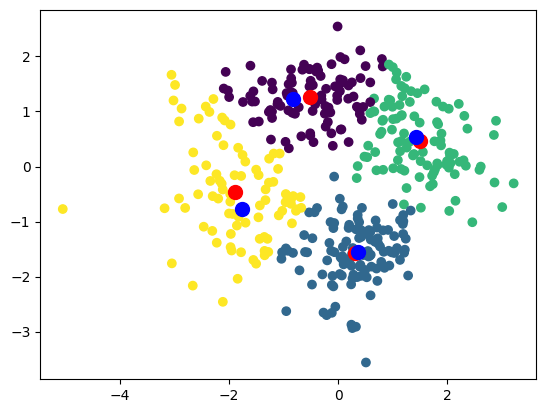

In [264]:
# Сравнение с scikit-learn

kmeans_sk = KMeans(
    n_clusters=4,
    random_state=42
)

labels_sk = kmeans_sk.fit_predict(X_pca)

centroids_sk = kmeans_sk.cluster_centers_

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_sk)

# Центроиды scikit-learn, красные
plt.scatter(
    centroids_sk[:, 0],
    centroids_sk[:, 1],
    c='red',
    marker='o',       # форма маркера
    s=100             # размер
)

# Центроиды ручной реализации, синие
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='blue',
    marker='o',       # форма маркера
    s=100             # размер
)

plt.show()

In [265]:
# Соотнесение центроидов scikit-learn и от ручной реализации по минимуму попарных расстояний

def match_centroids(c1, c2):
    k, n_features = c1.shape

    # Матрица расстояний
    distances = np.zeros((k, k))
    for j in range(k):
        centroid_array = np.tile(c1[j], (k, 1))   # повторение центроида
        diff = c2 - centroid_array                 # разность
        distances[:, j] = np.linalg.norm(diff, axis=1)  # построчная норма

    # Сопоставление по попарному расстоянию
    used = set()
    pairs = []

    for j in range(k):
        # минимальный ещё не использованный
        best_i = None
        best_dist = None

        for i in range(k):
            if i in used:
                continue
            if best_dist is None or distances[i, j] < best_dist:
                best_dist = distances[i, j]
                best_i = i

        used.add(best_i)
        pairs.append((j, best_i, best_dist))

    return distances, pairs

In [266]:
print(centroids_sk)
print(centroids)

[[-0.50824394  1.26762861]
 [ 0.32009418 -1.5644309 ]
 [ 1.50087289  0.46172278]
 [-1.88219322 -0.46168192]]
[[ 1.42262069  0.53366921]
 [-0.82795531  1.23456248]
 [-1.76107864 -0.7677965 ]
 [ 0.3736292  -1.55674272]]


In [267]:
distances, pairs = match_centroids(centroids_sk, centroids)
print('Матрица попарных расстояний между центроидами для двух методов', distances, 'Пары центроидов и расстояния', pairs, sep='\n\n')

Матрица попарных расстояний между центроидами для двух методов

[[2.06565597 2.3701453  0.10630002 3.45145171]
 [0.32141676 3.02529033 2.45371595 1.99716365]
 [2.39009417 2.22843144 3.4859784  0.3292034 ]
 [2.95884667 0.05408425 2.31189994 2.50756714]]

Пары центроидов и расстояния

[(0, 1, np.float64(0.3214167558329716)), (1, 3, np.float64(0.05408424917504692)), (2, 0, np.float64(0.10630002055684226)), (3, 2, np.float64(0.32920340056172626))]


Кластеризация в обеих реализациях дала очень близкие результаты. Отличия только в нескольких пограничных точках. В целом данные довольно разреженные, очевидных и отделенных скоплений точек в проекции PCA не наблюдается. PCA помогает привести данные к более удобной форме для kmeans, потому что уменьшает корреляцию и выделяет направления максимальной изменчивости. Удалось выделить кластеры. Координаты центроидов получились очень близкими.

**Этап 4. Итоговый анализ**

Что общего у дерева решений, ансамбля и кластеризации с точки зрения принципов разделения данных и интерпретации результатов?

Все три метода ищут, как разделить данные на понятные группы, правила разделения разные.
Дерево решений делит данные по предикатам и представляет собой набор четких правил, которые "задают вопросы" подаваемым данным при предсказании - больше или меньше.
Ансамблевые методы деревьев делают то же самое, но многократно и "смотрят" на данные под разными углами. Результат получается путем агрегации ответов участников ансамбля (среднее или большинство голосов). Методы с использованием решающих деревьев относятся к методам обучения с учителем.
Кластеризация делит данные на группы, не "задает вопросы", а ищет скопления похожих элементов. Относится к методам обучения без учителя.

Как параметры (глубина дерева, количество деревьев, число кластеров и др.) влияли на результаты?
Увеличение глубины дерева и малые количества элементов в листе приводит к разветвленным деревьям, которые скорее запоминают обучающую выборку, а не обобщают ее. Наблюдается сильная склонность к переобучению (на обучении хороший результат, на тесте плохой). Увеличение количества деревьев в ансамбле стабилизирует результат и повышает качество предсказаний. Изменение числа кластеров влияет на итоговый результат. Алгоритм разделит данные на почти любое количество кластеров. Подбор этого - главная трудность. PCA дает один из путей визуально оценить качество кластеризации и подобрать их число.

Какие трудности возникли при реализации алгоритмов и как вы их решали?

Нужно было подобрать число кластеров (выполнено методом проб и визуальной оценки). При построении деревьев важно было фиксировать random_state, чтобы получать воспроизводимые результаты и генерировать разные деревья в ансамбле. Также на малом объеме данных алгоритмы показывают худшие результаты, так как из такого набора сложнее выявить закономерности. Если количество точек увеличить, методы работают лучше, так как "заточены" именно под большие объемы данных.

Как вы проверяли корректность своих алгоритмов и воспроизводимость экспериментов?

Выполнялся вызов аналогичных алгоритмов из библиотеки scikit-learn с параметрами, соответствующими ручной реализации. Результаты получились очень близкие. Также помогает взгляд на результаты с точки зрения здравого смысла (проверка на аномальные результаты, слишком различные картины данных).